This notebook contains code that was utilized for processing the demultiplexed amplicon sequences. Further processing may have been performed in mothur or R.

This chunk is for generating a dataframe for the real sequencing data (subsample 100 events) as well as an in silico data set based off of the Poisson distribution (accounting for 16S copy number). The dataframe is outputted into a shared file to be normalized by mothur (same sequencing depth across samples) and generate a principle component analysis chart (PCA). PCA was chosen because the number of dimensions is relatively small, and PCA tends to reduce the variability into 3 dimensions which captures the data better than using a dissimilarity matrix and using a PCoA, which won't capture much of the variability. The resulting PCA is plotted with ggplot in R and then edited with Illustrator to make the figure in the manuscript.

In [ ]:
import pandas as pd
import numpy as np

def in_silico_mock(lambdas, label, n_instances, seed, multiplier):
# Generate Poisson-distributed data for each lambda
    np.random.seed(seed)
    
    lambda_df = pd.DataFrame()

    Bs_poisson = np.random.poisson(lambdas[0], n_instances)
    Bt_poisson = np.random.poisson(lambdas[1], n_instances)
    Ec_poisson = np.random.poisson(lambdas[2], n_instances)
    Pp_poisson = np.random.poisson(lambdas[3], n_instances)
    
    # Create a DataFrame for the current lambda
    # Multiply by 16S copy number to account for that
    #Multiplier is for subsampling, to increase the number of events from all samples for normalization downstream
    lambda_df['Bacillus_subtilis'] = Bs_poisson*10*multiplier
    lambda_df['Bacteroides_thetaiotaomicron'] = Bt_poisson*5*multiplier
    lambda_df['Escherichia_coli'] = Ec_poisson*7*multiplier
    lambda_df['Pseudomonas_putida'] = Pp_poisson*7*multiplier

    #lambda_df['Total'] = lambda_df[['Bacillus_subtilis','Bacteroides_thetaiotaomicron','Escherichia_coli','Pseudomonas_putida']].sum(axis=1)

    #lambda_df['Bacillus_subtilis'] = lambda_df['Bacillus_subtilis']/lambda_df['Total']
    #lambda_df['Bacteroides_thetaiotaomicron'] = lambda_df['Bacteroides_thetaiotaomicron']/lambda_df['Total']
    #lambda_df['Escherichia_coli'] = lambda_df['Escherichia_coli']/lambda_df['Total']
    #lambda_df['Pseudomonas_putida'] = lambda_df['Pseudomonas_putida']/lambda_df['Total']

    lambda_df['label'] = 'vsearch'
    lambda_df['numOtus'] = 4
    lambda_df['Group'] = "silico_%s" % (label)

    #for row_index in lambda_df.index:
    #    lambda_df.iat[row_index,7] = row_index+1

    #lambda_df = lambda_df.drop('Total', axis='columns')

    shared_file_order = ['label', 'Group', 'numOtus', 'Bacillus_subtilis','Bacteroides_thetaiotaomicron','Escherichia_coli','Pseudomonas_putida' ]
    lambda_df = lambda_df[shared_file_order]

    return lambda_df

#generate in silico mock community
# Lambda values (in order of Bs, Bt, Ec, Pp)
lambdas_even = [25, 25, 25, 25]
lambdas_log1 = [0.8, 90, 0.2, 9]
lambdas_log2 = [9, 0.2, 90, 0.8]
# generate dummy data to force 4 sided PCA plot
#lambdas_log3 = [0.2, 0.8, 9, 90]
#lambdas_log4 = [90, 9, 0.8, 0.2]

# Initialize an empty DataFrame
silico_even_df = in_silico_mock(lambdas_even, "even", 100, 42, 3)
silico_log1_df = in_silico_mock(lambdas_log1, "log1", 100, 42, 3)
silico_log2_df = in_silico_mock(lambdas_log2, "log2", 100, 42, 3)
#silico_log3_df = in_silico_mock(lambdas_log3, "log3", 100, 42, 3)
#silico_log4_df = in_silico_mock(lambdas_log4, "log4", 100, 42, 3)

concat_silico_df = pd.concat([silico_even_df, silico_log1_df, silico_log2_df], axis = 0)
#concat_silico_df = pd.concat([silico_even_df, silico_log1_df, silico_log2_df, silico_log3_df, silico_log4_df], axis = 0)
#concat_silico_df.to_csv('silico_data.tsv', sep='\t', index=False)

#process the real mock community data
even_df = pd.read_csv('even/even.shared', delimiter = '\t')
log1_df = pd.read_csv('log1/log1.shared', delimiter = '\t')
log2_df = pd.read_csv('log2/log2.shared', delimiter = '\t')
                      
subsampled_even_df = even_df.sample(n=100, random_state=42)  # random_state for reproducibility
subsampled_log1_df = log1_df.sample(n=100, random_state=42)
subsampled_log2_df = log2_df.sample(n=100, random_state=42)

subsampled_even_df['Group'] = 'even'
subsampled_log1_df['Group'] = 'log1'
subsampled_log2_df['Group'] = 'log2'

concat_subsampled_df = pd.concat([subsampled_even_df, subsampled_log1_df, subsampled_log2_df], axis=0)

#Removed 16S copy number and multiplied that in the insilico data to account for it instead
concat_subsampled_df['Bacillus_subtilis'] = concat_subsampled_df['Bacillus_subtilis']
concat_subsampled_df['Bacteroides_thetaiotaomicron'] = concat_subsampled_df['Bacteroides_thetaiotaomicron']
concat_subsampled_df['Escherichia_coli'] = concat_subsampled_df['Escherichia_coli']
concat_subsampled_df['Pseudomonas_putida'] = concat_subsampled_df['Pseudomonas_putida']

#DO NOT NORMALIZE W/ REL ABUNDANCE, PCA WONT LIKE IT
#concat_subsampled_df['Total'] = concat_subsampled_df[['Bacillus_subtilis','Bacteroides_thetaiotaomicron','Escherichia_coli','Pseudomonas_putida']].sum(axis=1)
#concat_subsampled_df['Bacillus_subtilis'] = concat_subsampled_df['Bacillus_subtilis']/concat_subsampled_df['Total']
#concat_subsampled_df['Bacteroides_thetaiotaomicron'] = concat_subsampled_df['Bacteroides_thetaiotaomicron']/concat_subsampled_df['Total']
#concat_subsampled_df['Escherichia_coli'] = concat_subsampled_df['Escherichia_coli']/concat_subsampled_df['Total']
#concat_subsampled_df['Pseudomonas_putida'] = concat_subsampled_df['Pseudomonas_putida']/concat_subsampled_df['Total']
#concat_subsampled_df = concat_subsampled_df.drop('Total', axis='columns')
#concat_subsampled_df.to_csv('real_data.tsv', sep='\t', index=False)

#vertices of PCA space
ref_df = pd.DataFrame({
    'label': ['vsearch', 'vsearch', 'vsearch','vsearch'],
    'Group': ['Bs', 'Bt', 'Ec','Pp'],
    'numOtus': [4, 4, 4, 4],
    'Bacillus_subtilis': [1000, 0, 0, 0],
    'Bacteroides_thetaiotaomicron': [0, 1000, 0, 0],
    'Escherichia_coli': [0, 0, 1000, 0],
    'Pseudomonas_putida': [0, 0, 0, 1000]
})

#combine dataframes into one .shared file to be processed in mothur to subsample and to make the PCA plot
combined_data_df = pd.concat([concat_subsampled_df, concat_silico_df, ref_df], axis=0)
combined_data_df.to_csv('mock_pca_data.shared', sep='\t', index=False)
               

This code chunk converts the abundance dataframe into a presence/absence and then % prevelance and compares to expectation.

/var/folders/5s/wnbg69qs21sbr4ywzl06130w0000gn/T/ipykernel_24702/1765010678.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '55.9' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prev_rar100_df.iloc[3,1:5] = silico_log1_df_prev_sums
/var/folders/5s/wnbg69qs21sbr4ywzl06130w0000gn/T/ipykernel_24702/1765010678.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '18.6' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prev_rar100_df.iloc[3,1:5] = silico_log1_df_prev_sums
/var/folders/5s/wnbg69qs21sbr4ywzl06130w0000gn/T/ipykernel_24702/1765010678.py:111: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '19.6' has dtype incompatible with int64, please explicitly cast

type library Species  Prevalence(%)  Prevalence_insilico(%)
0       even      Bs     100.000000                   100.0
1       even      Bt      96.754250                   100.0
2       even      Ec      99.768161                   100.0
3       even      Pp      98.145286                   100.0
4      log-1      Bs      73.395722                    55.9
5      log-1      Bt     100.000000                   100.0
6      log-1      Ec      21.390374                    18.6
7      log-1      Pp      90.975936                   100.0
8      log-2      Bs      99.595960                    99.9
9      log-2      Bt      22.760943                    19.6
10     log-2      Ec     100.000000                   100.0
11     log-2      Pp      73.131313                    54.2
Linear regression equation: y = 1.0869x + -9.3778
R-squared: 0.9458
   library Species  Rel_abund(%)  Rel_abund_std  Rel_abund_insilico(%)  \
0     even      Bs     53.643526      12.112132              34.218398   
1   

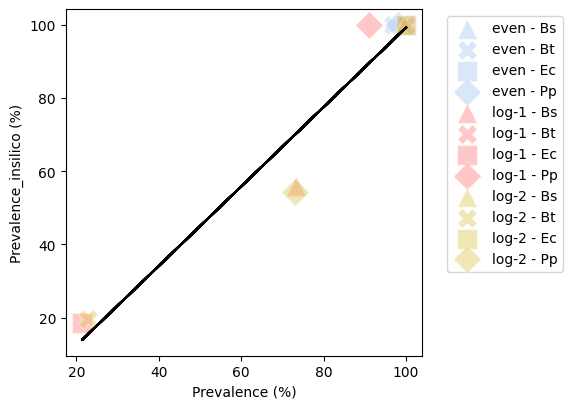

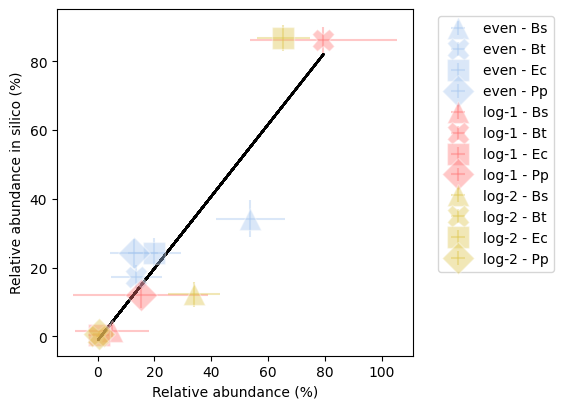

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

def in_silico_mock(lambdas, label, n_instances, seed, multiplier):
# Generate Poisson-distributed data for each lambda
    np.random.seed(seed)
    
    lambda_df = pd.DataFrame()

    Bs_poisson = np.random.poisson(lambdas[0], n_instances)
    Bt_poisson = np.random.poisson(lambdas[1], n_instances)
    Ec_poisson = np.random.poisson(lambdas[2], n_instances)
    Pp_poisson = np.random.poisson(lambdas[3], n_instances)
    
    # Create a DataFrame for the current lambda
    # Multiply by 16S copy number to account for that
    #Multiplier is for subsampling, to increase the number of events from all samples for normalization downstream
    lambda_df['Bacillus_subtilis'] = Bs_poisson*10*multiplier
    lambda_df['Bacteroides_thetaiotaomicron'] = Bt_poisson*5*multiplier
    lambda_df['Escherichia_coli'] = Ec_poisson*7*multiplier
    lambda_df['Pseudomonas_putida'] = Pp_poisson*7*multiplier

    #lambda_df['Total'] = lambda_df[['Bacillus_subtilis','Bacteroides_thetaiotaomicron','Escherichia_coli','Pseudomonas_putida']].sum(axis=1)

    #lambda_df['Bacillus_subtilis'] = lambda_df['Bacillus_subtilis']/lambda_df['Total']
    #lambda_df['Bacteroides_thetaiotaomicron'] = lambda_df['Bacteroides_thetaiotaomicron']/lambda_df['Total']
    #lambda_df['Escherichia_coli'] = lambda_df['Escherichia_coli']/lambda_df['Total']
    #lambda_df['Pseudomonas_putida'] = lambda_df['Pseudomonas_putida']/lambda_df['Total']

    lambda_df['label'] = 'vsearch'
    lambda_df['numOtus'] = 4
    lambda_df['Group'] = "silico_%s" % (label)

    #for row_index in lambda_df.index:
    #    lambda_df.iat[row_index,7] = row_index+1

    #lambda_df = lambda_df.drop('Total', axis='columns')

    shared_file_order = ['label', 'Group', 'numOtus', 'Bacillus_subtilis','Bacteroides_thetaiotaomicron','Escherichia_coli','Pseudomonas_putida' ]
    lambda_df = lambda_df[shared_file_order]

    return lambda_df

def prevalence(df):
    df_copy = df.copy()
    
    df_copy.loc[:,'Bacillus_subtilis':'Pseudomonas_putida']=np.where(df_copy.loc[:,'Bacillus_subtilis':'Pseudomonas_putida']>0,1,0)
    tot_inst = df_copy.shape[0]
    df_prev_sums = df_copy.loc[:,'Bacillus_subtilis':'Pseudomonas_putida'].sum()*100/tot_inst
    return df_prev_sums

def average_rel_abun(df):

    df_copy = df.copy()

    columns = ['Bacillus_subtilis','Bacteroides_thetaiotaomicron','Escherichia_coli','Pseudomonas_putida']
    df_copy['Total'] = df_copy[columns].sum(axis=1)
    df_copy['Total'] = df_copy['Total'].replace(0, np.nan)  # Avoid division by zero

    for col in columns:
        df_copy[col] = df_copy[col] * 100 / df_copy['Total']

    avg_rel_abun = df_copy.loc[:,'Bacillus_subtilis':'Pseudomonas_putida'].mean()
    std_rel_abun = df_copy.loc[:,'Bacillus_subtilis':'Pseudomonas_putida'].std()

    return avg_rel_abun, std_rel_abun

#generate in silico mock community
# Lambda values (in order of Bs, Bt, Ec, Pp)
lambdas_even = [25, 25, 25, 25]
lambdas_log1 = [0.8, 90, 0.2, 9]
lambdas_log2 = [9, 0.2, 90, 0.8]

silico_even_df = in_silico_mock(lambdas_even, "even", 1000, 42, 3)
silico_log1_df = in_silico_mock(lambdas_log1, "log1", 1000, 42, 3)
silico_log2_df = in_silico_mock(lambdas_log2, "log2", 1000, 42, 3)

silico_even_df_prev_sums = prevalence(silico_even_df)
silico_log1_df_prev_sums = prevalence(silico_log1_df)
silico_log2_df_prev_sums = prevalence(silico_log2_df)

silico_even_df_relabund, silico_even_df_relabund_std  = average_rel_abun(silico_even_df)
silico_log1_df_relabund, silico_log1_df_relabund_std = average_rel_abun(silico_log1_df)
silico_log2_df_relabund, silico_log2_df_relabund_std = average_rel_abun(silico_log2_df)

prev_data  = {
    'library': ['even_real', 'even_silico', 'log-1_real', 'log-1_silico', 'log-2_real', 'log-2_silico'],
    'Bs': [0,0,0,0,0,0],
    'Bt': [0,0,0,0,0,0],
    'Ec': [0,0,0,0,0,0],
    'Pp': [0,0,0,0,0,0]
}

relabund_data  = {
    'library': ['even_real_mean', 'even_silico_mean', 'log-1_real_mean', 'log-1_silico_mean', 'log-2_real_mean', 'log-2_silico_mean','even_real_std', 'even_silico_std', 'log-1_real_std', 'log-1_silico_std', 'log-2_real_std', 'log-2_silico_std'],
    'Bs': [0,0,0,0,0,0,0,0,0,0,0,0],
    'Bt': [0,0,0,0,0,0,0,0,0,0,0,0],
    'Ec': [0,0,0,0,0,0,0,0,0,0,0,0],
    'Pp': [0,0,0,0,0,0,0,0,0,0,0,0]
}

prev_rar100_df = pd.DataFrame(prev_data)
prev_rar100_df.iloc[1,1:5] = silico_even_df_prev_sums
prev_rar100_df.iloc[3,1:5] = silico_log1_df_prev_sums
prev_rar100_df.iloc[5,1:5] = silico_log2_df_prev_sums

relabund_rar100_df = pd.DataFrame(relabund_data)
relabund_rar100_df.iloc[1,1:5] = silico_even_df_relabund
relabund_rar100_df.iloc[3,1:5] = silico_log1_df_relabund
relabund_rar100_df.iloc[5,1:5] = silico_log2_df_relabund
relabund_rar100_df.iloc[7,1:5] = silico_even_df_relabund_std
relabund_rar100_df.iloc[9,1:5] = silico_log1_df_relabund_std
relabund_rar100_df.iloc[11,1:5] = silico_log2_df_relabund_std

#process the real mock community data
even_df = pd.read_csv('even/even.shared', delimiter = '\t')
log1_df = pd.read_csv('log1/log1.shared', delimiter = '\t')
log2_df = pd.read_csv('log2/log2.shared', delimiter = '\t')

#generate both prevalence and rel abundance data
even_df_prev_sums_rar100 = prevalence(even_df)
log1_df_prev_sums_rar100 = prevalence(log1_df)
log2_df_prev_sums_rar100 = prevalence(log2_df)

even_df_relabun_sums_rar100, even_df_relabun_std_sums_rar100 = average_rel_abun(even_df)
log1_df_relabun_sums_rar100, log1_df_relabun_std_sums_rar100 = average_rel_abun(log1_df)
log2_df_relabun_sums_rar100, log2_df_relabun_std_sums_rar100 = average_rel_abun(log2_df)

prev_rar100_df.iloc[0,1:5] = even_df_prev_sums_rar100
prev_rar100_df.iloc[2,1:5] = log1_df_prev_sums_rar100
prev_rar100_df.iloc[4,1:5] = log2_df_prev_sums_rar100

relabund_rar100_df.iloc[0,1:5] = even_df_relabun_sums_rar100
relabund_rar100_df.iloc[2,1:5] = log1_df_relabun_sums_rar100
relabund_rar100_df.iloc[4,1:5] = log2_df_relabun_sums_rar100
relabund_rar100_df.iloc[6,1:5] = even_df_relabun_std_sums_rar100
relabund_rar100_df.iloc[8,1:5] = log1_df_relabun_std_sums_rar100
relabund_rar100_df.iloc[10,1:5] = log2_df_relabun_std_sums_rar100

df_long = prev_rar100_df.melt(id_vars='library', var_name='Species', value_name='Prevalence(%)')

df_ra_long = relabund_rar100_df.melt(id_vars='library', var_name='Species', value_name='Rel_abundance(%)')

## Make correlation graph to show that these prelevance values are correlated between expectation and cocoa-seq

# Extract real/silico from the 'library' column
df_long['type'] = df_long['library'].apply(lambda x: 'real' if 'real' in x else 'silico')

# Create a normalized library name (e.g., remove "_real" or "_silico")
df_long['library_base'] = df_long['library'].str.replace(r'_(real|silico)', '', regex=True)

# Pivot the table to get both values in the same row
pivot_df_long = df_long.pivot_table(index=['library_base', 'Species'], 
                          columns='type', 
                          values='Prevalence(%)').reset_index()

# Rename columns
pivot_df_long = pivot_df_long.rename(columns={
    'real': 'Prevalence(%)',
    'silico': 'Prevalence_insilico(%)',
    'library_base': 'library'
})

palette = {'even': '#A4C5EE', 'log-1': '#ff7373', 'log-2': '#dec54a'}
markers = {'Bs': '^', 'Bt': 'X', 'Ec': 's', 'Pp': 'D'}

# Assuming pivot_df is the DataFrame with both columns
x = pivot_df_long['Prevalence(%)']
y = pivot_df_long['Prevalence_insilico(%)']

print(pivot_df_long)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Print results
print(f"Linear regression equation: y = {slope:.4f}x + {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")

fig, ax = plt.subplots(figsize=(4.6, 4.5))
for _, row in pivot_df_long.iterrows():
    ax.scatter(
        row['Prevalence(%)'],
        row['Prevalence_insilico(%)'],
        marker=markers[row['Species']],
        color=palette[row['library']],
        s=200,
        edgecolor='white',
        alpha=0.4,
        label=f"{row['library']} - {row['Species']}"
    )
    plt.plot(x, slope*x + intercept, color='black')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_xlabel("Prevalence (%)")
    ax.set_ylabel("Prevalence_insilico (%)")

    plt.savefig('prevalence_correlation.pdf',bbox_inches='tight')

# Make correlation graph to show that these rel abundance values are correlated between expectation and cocoa-seq

# Extract real/silico from the 'library' column
df_ra_long['stat_type'] = df_ra_long['library'].apply(
    lambda x: 'std' if 'std' in x else 'mean'
)
df_ra_long['type'] = df_ra_long['library'].apply(lambda x: 'real' if 'real' in x else 'silico')

# Create a normalized library name (e.g., remove "_real" or "_silico")
df_ra_long['library_base'] = df_ra_long['library'].str.replace(r'_(real|silico|mean|std)', '', regex=True)

# Pivot the table to get both values in the same row
pivot_df_ra_long = df_ra_long.pivot_table(index=['library_base', 'Species'], 
                          columns=['type','stat_type'], 
                          values=['Rel_abundance(%)']).reset_index()

# Rename columns
pivot_df_ra_long.columns = [
    'library', 'Species', 
    'Rel_abund(%)', 'Rel_abund_std', 
    'Rel_abund_insilico(%)', 'Rel_abund_insilico_std'
]

print(pivot_df_ra_long)

# Assuming pivot_df is the DataFrame with both columns
x = pivot_df_ra_long['Rel_abund(%)']
y = pivot_df_ra_long['Rel_abund_insilico(%)']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Print results
print(f"Linear regression equation: y = {slope:.4f}x + {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")

fig, ax = plt.subplots(figsize=(4.6, 4.5))
for _, row in pivot_df_ra_long.iterrows():
    ax.errorbar(
        row['Rel_abund(%)'],
        row['Rel_abund_insilico(%)'],
        xerr=row['Rel_abund_std'],
        yerr=row['Rel_abund_insilico_std'],
        fmt=markers[row['Species']],
        color=palette[row['library']],
        markersize=16,
        markeredgecolor='white',
        alpha=0.4,
        label=f"{row['library']} - {row['Species']}"
    )
    plt.plot(x, slope*x + intercept, color='black')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_xlabel("Relative abundance (%)")
    ax.set_ylabel("Relative abundance in silico (%)")

    plt.savefig('relabund_correlation.pdf',bbox_inches='tight')


Want to see if the pair-wise relative abundance distributions between the observed and expected are statistically significant from each other.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

def in_silico_mock(lambdas, label, n_instances, seed, multiplier):
# Generate Poisson-distributed data for each lambda
    np.random.seed(seed)
    
    lambda_df = pd.DataFrame()

    Bs_poisson = np.random.poisson(lambdas[0], n_instances)
    Bt_poisson = np.random.poisson(lambdas[1], n_instances)
    Ec_poisson = np.random.poisson(lambdas[2], n_instances)
    Pp_poisson = np.random.poisson(lambdas[3], n_instances)
    
    # Create a DataFrame for the current lambda
    # Multiply by 16S copy number to account for that
    #Multiplier is for subsampling, to increase the number of events from all samples for normalization downstream
    lambda_df['Bacillus_subtilis'] = Bs_poisson*10*multiplier
    lambda_df['Bacteroides_thetaiotaomicron'] = Bt_poisson*5*multiplier
    lambda_df['Escherichia_coli'] = Ec_poisson*7*multiplier
    lambda_df['Pseudomonas_putida'] = Pp_poisson*7*multiplier

    #lambda_df['Total'] = lambda_df[['Bacillus_subtilis','Bacteroides_thetaiotaomicron','Escherichia_coli','Pseudomonas_putida']].sum(axis=1)

    #lambda_df['Bacillus_subtilis'] = lambda_df['Bacillus_subtilis']/lambda_df['Total']
    #lambda_df['Bacteroides_thetaiotaomicron'] = lambda_df['Bacteroides_thetaiotaomicron']/lambda_df['Total']
    #lambda_df['Escherichia_coli'] = lambda_df['Escherichia_coli']/lambda_df['Total']
    #lambda_df['Pseudomonas_putida'] = lambda_df['Pseudomonas_putida']/lambda_df['Total']

    lambda_df['label'] = 'vsearch'
    lambda_df['numOtus'] = 4
    lambda_df['Group'] = "silico_%s" % (label)

    #for row_index in lambda_df.index:
    #    lambda_df.iat[row_index,7] = row_index+1

    #lambda_df = lambda_df.drop('Total', axis='columns')

    shared_file_order = ['label', 'Group', 'numOtus', 'Bacillus_subtilis','Bacteroides_thetaiotaomicron','Escherichia_coli','Pseudomonas_putida' ]
    lambda_df = lambda_df[shared_file_order]

    return lambda_df

def rel_abun(df):

    df_copy = df.copy()

    columns = ['Bacillus_subtilis','Bacteroides_thetaiotaomicron','Escherichia_coli','Pseudomonas_putida']
    df_copy['Total'] = df_copy[columns].sum(axis=1)
    df_copy['Total'] = df_copy['Total'].replace(0, np.nan)  # Avoid division by zero

    for col in columns:
        df_copy[col] = df_copy[col] * 100 / df_copy['Total']

    return df_copy

def t_test(df1, df2):
    
    t_test_Bs, p_val_Bs = ttest_ind(df1['Bacillus_subtilis'], df2['Bacillus_subtilis'], equal_var=False)
    t_test_Bt, p_val_Bt = ttest_ind(df1['Bacteroides_thetaiotaomicron'], df2['Bacteroides_thetaiotaomicron'], equal_var=False)
    t_test_Ec, p_val_Ec = ttest_ind(df1['Escherichia_coli'], df2['Escherichia_coli'], equal_var=False)
    t_test_Pp, p_val_Pp = ttest_ind(df1['Pseudomonas_putida'], df2['Pseudomonas_putida'], equal_var=False)

    p_val = [p_val_Bs, p_val_Bt, p_val_Ec, p_val_Pp]

    return p_val

#generate in silico mock community
# Lambda values (in order of Bs, Bt, Ec, Pp)
lambdas_even = [25, 25, 25, 25]
lambdas_log1 = [0.8, 90, 0.2, 9]
lambdas_log2 = [9, 0.2, 90, 0.8]

silico_even_df = in_silico_mock(lambdas_even, "even", 1000, 42, 3)
silico_log1_df = in_silico_mock(lambdas_log1, "log1", 1000, 42, 3)
silico_log2_df = in_silico_mock(lambdas_log2, "log2", 1000, 42, 3)

silico_even_df_relabund  = rel_abun(silico_even_df)
silico_log1_df_relabund = rel_abun(silico_log1_df)
silico_log2_df_relabund = rel_abun(silico_log2_df)

#process the real mock community data
even_df = pd.read_csv('even/even.shared', delimiter = '\t')
log1_df = pd.read_csv('log1/log1.shared', delimiter = '\t')
log2_df = pd.read_csv('log2/log2.shared', delimiter = '\t')

#generate rel abundance data
even_df_relabun = rel_abun(even_df)
log1_df_relabun = rel_abun(log1_df)
log2_df_relabun = rel_abun(log2_df)

p_value_data  = {
    'library': ['even', 'log-1', 'log-2'],
    'Bs': [0,0,0],
    'Bt': [0,0,0],
    'Ec': [0,0,0],
    'Pp': [0,0,0]
}

p_value_df = pd.DataFrame(p_value_data)
p_value_df.set_index('library', inplace=True)
p_value_df = p_value_df.T

p_value_df['even'] = t_test(silico_even_df_relabund,even_df_relabun)
p_value_df['log-1'] = t_test(silico_log1_df_relabund,log1_df_relabun)
p_value_df['log-2'] = t_test(silico_log2_df_relabund,log2_df_relabun)

print(p_value_df)


library           even         log-1     log-2
Bs        0.000000e+00  1.710158e-24  0.000000
Bt        2.234512e-39  2.340464e-23  0.191791
Ec        6.082775e-46  2.107887e-01  0.000000
Pp       1.124916e-282  2.361110e-07  0.035823


As expected, basically everything is statistically significant from each other. Makes sense.